In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from helper_functions import *
import plotly.graph_objects as go


# Constructing a helix using the _Joint Face Normal Method_

This notebook will implement the following algorithm:

Given :
- the length $L$ of an object,
- the angles between the axis and the normal vectors of the joint faces $\theta/2$, where the angles are assumed to be the same but in opposite directions and the two face normals and the axis are co-planar. Note that the total angle between the planes defined by the joint faces are $\theta$, which is consistent with the reference,
- the twist angle $\tau$. This is the same angle described in the reference.

All relevant properties of the matrix will be computed. Then later, practical methods to find the right parameters for the welding application.

## Homogeneous coordinates and rigid transformations

In **homogeneous coordinates** in 3D, a space is described by a vector $(x, y, z, w)$. The corresponding cartesian coordinates are $(x/w, y/w, z/w)$. The point $(x, y, z, 0)$ signifies the point 'at infinity, so meaning a direction.

**Rigid body transormations** are transormations, where all distances are preserved. They include rotations and translations, which is all that is important here. The transformation matrix is of the form:

$$
M = \begin{pmatrix} r_{11}&r_{12}&r_{13}&t_x\\ r_{21}&r_{22}&r_{23}&t_y \\ r_{31}&r_{32}&r_{33}&t_z \\ 0 & 0& 0& 1\end{pmatrix}
$$

Where the matrix $R \in SO(3)$ is a rotation matrix and $\vec t$ the translation vector.

## The algorithm

To construct the helix, we will assume that the first point B lies at the origin. 
The first segment goes in the x direction, so C is at $(L,0,0,1)$.
Further, the joint faces of the first segment are normal to the $xy$-plane, meaning
$$N_B = (-\cos(\theta/2), \sin(\theta/2), 0, 1)\quad N_C = (\cos(\theta/2), \sin(\theta/2), 0, 1)$$
which are the normal vectors to the joint faces.

Note that this means that the axis of the helix is not the $z$-axis, and it is in fact not even parallel to it unless the twist angle $\tau$ is 0.

To determine the third point A we do the following:

1. translate C to the origin ($\vec t = (-L, 0, 0), R = \mathbf 1$)
2. rotate by $-\theta/2$ along the $z$-axis. Now $\vec N_B$ is aligned with the $x$-axis.
3. rotate by $\tau$ around the $x$-axis.
4. rotate by $-\theta/2$ around the $z$-axis again. Now the point D would lie where C was before, and B has moved to A.

Doing this transformation to B will give you A, and doing the inverse to C will give you D.

In [2]:
## Defining parameters

L = 60 ## mm
theta = 15 ## degrees
theta_rad = np.deg2rad(theta)
tau = 15 ## degrees
tau_rad = np.deg2rad(tau)

In [3]:
B = np.array([0,0,0,1])
C = np.array([L,0,0,1])

## translate b to origin
T1 = np.array([[1,0,0,-L],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]])

## rotate by -theta/2 around z axis
R1 = np.array([[math.cos(-theta_rad/2), -math.sin(-theta_rad/2), 0, 0],
                [math.sin(-theta_rad/2), math.cos(-theta_rad/2), 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

## rotate by tau around x axis
R2 = np.array([[1, 0, 0, 0],
                [0, math.cos(tau_rad), -math.sin(tau_rad), 0],
                [0, math.sin(tau_rad), math.cos(tau_rad), 0],
                [0, 0, 0, 1]])

## rotate by -tau around x axis
R2_inv = np.array([[1, 0, 0, 0],
                    [0, math.cos(-tau_rad), -math.sin(-tau_rad), 0],
                    [0, math.sin(-tau_rad), math.cos(-tau_rad), 0],
                    [0, 0, 0, 1]])  

## rotate by theta/2 around z axis
R3 = np.array([[math.cos(theta_rad/2), -math.sin(theta_rad/2), 0, 0],
                [math.sin(theta_rad/2), math.cos(theta_rad/2), 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

## translate back
T2 = np.array([[1,0,0,L],
                [0,1,0,0],        
                [0,0,1,0],
                [0,0,0,1]])


M = R1@R2@R1@T1
inverse_M = np.linalg.inv(M)
inverse_M_from_scratch = T2@R3@R2_inv@R3

if np.allclose(inverse_M, inverse_M_from_scratch):
    print("OK. Inverse matrix calculation is consistent")
else:  
    print("Inverse matrix calculation is NOT consistent")
    raise ValueError("Inverse matrix calculation is NOT consistent")

OK. Inverse matrix calculation is consistent


In [4]:
A = np.array(M@B)
D = inverse_M@C

A

array([-57.99038106,  15.26457135,   2.02695987,   1.        ])

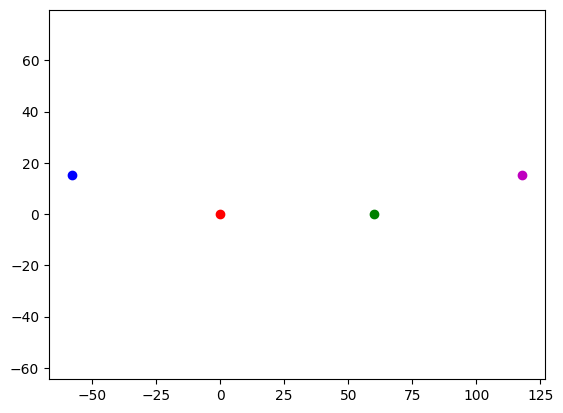

In [5]:
plt.plot(B[0], B[1], 'ro', label='B')
plt.plot(C[0], C[1], 'go', label='C')
plt.plot(A[0], A[1], 'bo', label='A')
plt.plot(D[0], D[1], 'mo', label='D')
plt.axis('equal')

Bcart = homogeneous_to_cartesian(B)
x, y, z = Bcart.T

points = generate_point_on_helix(25, Bcart, M)
axis_origin, axis_direction = find_helix_axis(points[5], M)
# axis_direction = find_axis_ev(M)
points_straight = transform_points(points.copy(), axis_origin, axis_direction)

In [10]:
x, y, z = points.T


fig = go.Figure()

rotated = turn_spiral_about_z_axis(points_straight)
x,y,z = rotated.T
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, ))


x, y, z = points_straight.T
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, ))


#x, y, z = make_line(axis_origin + axis_direction * 500, axis_direction, length=1000).T
#fig.add_trace(go.Scatter3d(x=x, y=y, z=z, ))


#fig.update_layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=None, autorange=True),
        yaxis=dict(range=None, autorange=True),
        zaxis=dict(range=None, autorange=True)
    )
)
fig.update_layout(
    scene=dict(
        aspectmode='data'   # ensures equal scaling for x, y, z
    )
)

fig.update_layout(
    template="plotly_white",          # clean background
    scene=dict(
        aspectmode="data",            # equal axes
        xaxis=dict(showbackground=False, showgrid=True, zeroline=False),
        yaxis=dict(showbackground=False, showgrid=True, zeroline=False),
        zaxis=dict(showbackground=False, showgrid=True, zeroline=False),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    font=dict(size=14, family="Arial"),
)

fig.update_layout(
    dragmode="turntable",        # intuitive rotation
    scene_camera=dict(eye=dict(x=4, y=1.8, z=1.2)),  # pleasant starting view
)

fig.update_traces(marker=dict(size=3, color='blue'))
fig.update_layout(showlegend=False, title_text="Helical path straightened along its axis")


fig.show()  # fully interactive in browser/notebook
fig.write_html("plot.html")  # shareable file

## Identifying the axis of the helix

By the reference, the vector of the helix Matrix is given by

$$
(M^2 q) -q
$$

where M is the transormation matrix and q is any vector.

In [7]:
def point_line_distance(P, A, v):
    """
    Distance between point P and line passing through A with direction v.
    """
    P, A, v = map(lambda x: np.asarray(x, float), (P, A, v))
    return np.linalg.norm(np.cross(P - A, v)) / np.linalg.norm(v)

BC = points[1] - points[0]
CD = points[2] - points[1]

def angle(v1, v2):
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    dot_product = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.rad2deg(angle_rad)

angle_BCD = angle(BC, CD)
angle_BCD, point_line_distance(points_straight[2], [0,0,0], [0,0,1])

(14.870944452263695, 114.91522199999108)

In [8]:
## How many for desired length?

length = 1005 # mm

def find_number_of_segments_for_length(points_in, length):
    delta_points = np.diff(points_in.copy(), axis=0)
    assert np.allclose(delta_points[:,2], delta_points[0,2])
    deltaz = delta_points[0,2]
    number = int(np.ceil(length/deltaz))

    return length, deltaz, number, deltaz*number

find_number_of_segments_for_length(points_straight, length)

(1005, 42.60827523443152, 24, 1022.5986056263564)

In [9]:
def find_axis_ev(M_in):
    M = M_in.copy()[:3,:3]
    vals, vecs = np.linalg.eig(M)

    axis_vec = np.real(vecs[:, np.isclose(vals, 1.)])

    #test if it actually an eigenvector
    assert np.allclose(M@axis_vec, axis_vec), "Computation of eigenvector failed"

    unit(axis_vec)

    return axis_vec[:,0]
 
axis_ev = find_axis_ev(M)

find_helix_axis(points[5], M)[1], axis_ev

(array([-7.10137921e-01,  2.00114010e-15,  7.04062592e-01]),
 array([-7.10137921e-01, -2.07470556e-16,  7.04062592e-01]))